In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-planet/Train_Data.csv
/kaggle/input/ai-planet/Test_Data.csv


### Problem Statement

In this challenge, you will work on a dataset that contains news headlines - which are aimed to be written in a sarcastic manner by the news author. Our job here is to build our NLP models and predict whether the headline is sarcastic or not.

Evaluation metrics - Accuracy score

In [2]:
!pip install contractions

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style,rcParams
style.use('seaborn-white')
import warnings
warnings.filterwarnings('ignore')
import re
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
import wordcloud
import string

import itertools
import collections
from collections import Counter

import nltk
import contractions
import re

import textblob

## for feature extraction

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
## machine learning libary
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [5]:
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [9]:
train = pd.read_csv('/kaggle/input/ai-planet/Train_Data.csv')
test = pd.read_csv('/kaggle/input/ai-planet/Test_Data.csv')

In [10]:
train.head()

headline  is_sarcastic
0  supreme court votes 7-2 to legalize all worldl...             1
1  hungover man horrified to learn he made dozens...             1
2  emily's list founder: women are the 'problem s...             0
3      send your kids back to school with confidence             0
4          watch: experts talk pesticides and health             0

In [11]:
print('we have {} rows in our trainmset'.format(train.shape[0]))
print('we have {} columns in our train set'.format(train.shape[1]))

we have 44262 rows in our trainmset
we have 2 columns in our train set


In [12]:
print('we have {} rows in our test set'.format(test.shape[0]))
print('we have {} columns in our test set'.format(test.shape[1]))

we have 11066 rows in our test set
we have 1 columns in our test set


### EDA on the data

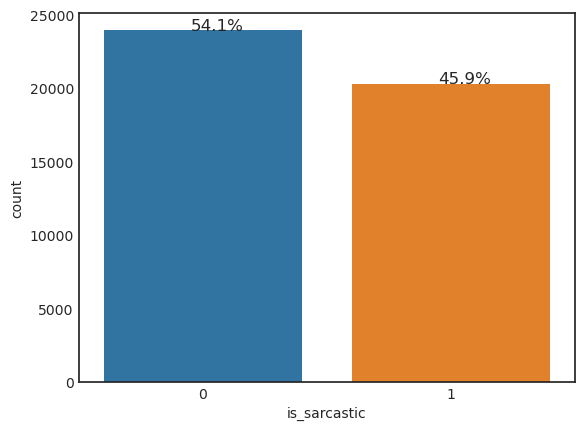

In [13]:
ax = sns.countplot(x='is_sarcastic', data=train, order = train['is_sarcastic'].value_counts().index)
without_hue(ax, train['is_sarcastic'])

The dataset is slightly balanced

In [14]:
train['headline'].iloc[6]

'u.s. dignity reserves nearly depleted'

## Analyze the data using wordcloud

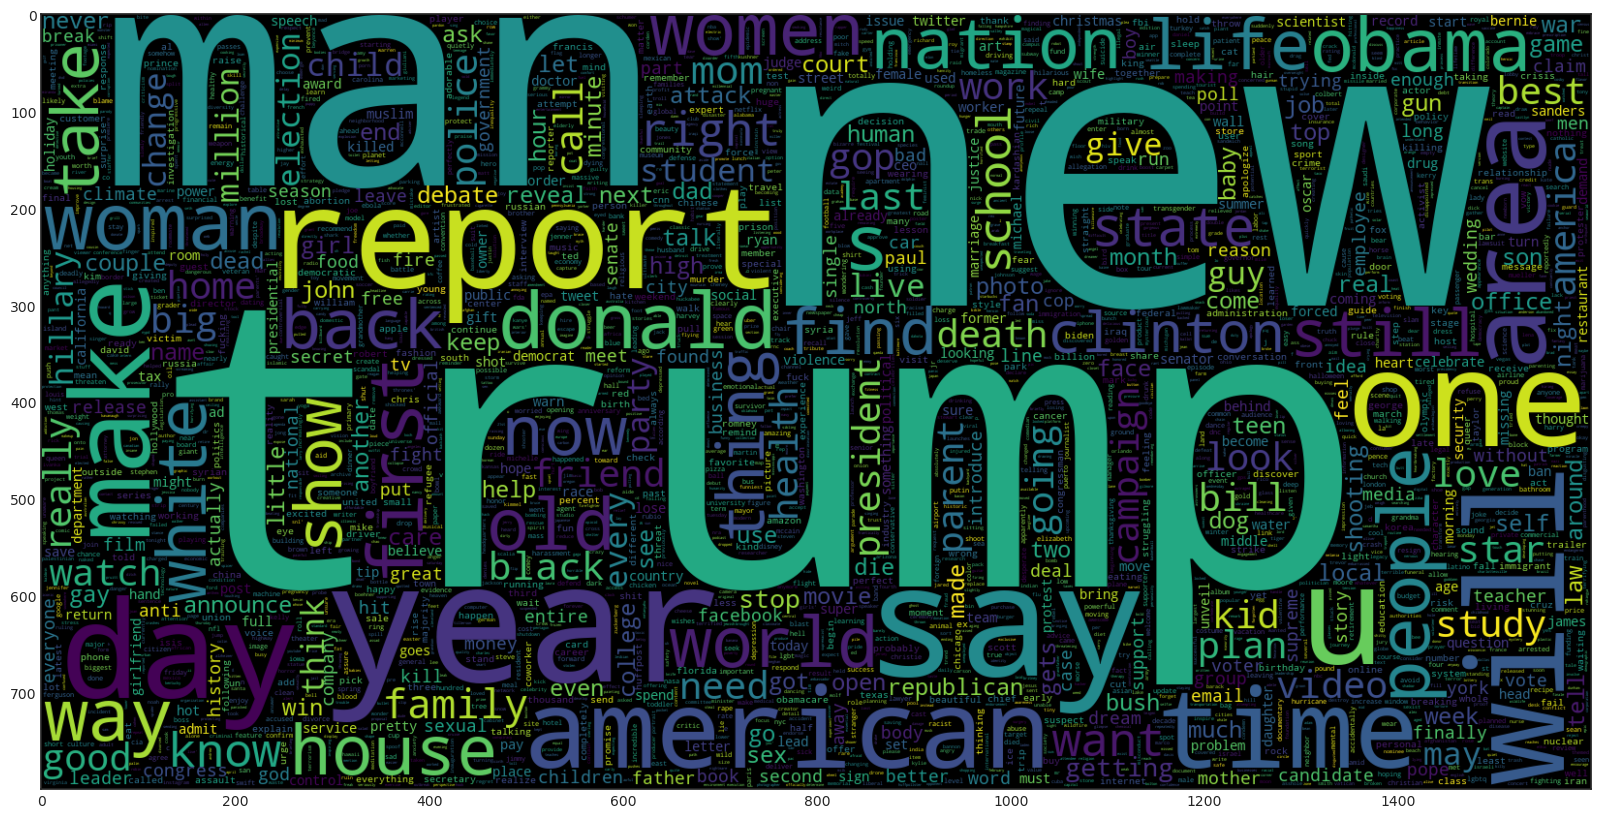

In [15]:
data_word = train['headline']
plt.figure(figsize = (20,20))
wc = WordCloud(stopwords=wordcloud.STOPWORDS, max_words = 5000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_word))
plt.imshow(wc,interpolation='bilinear')

The word cloud simply define that the headline is about a nation called american and consistent of EX president Donald Trump and Obama.

### Word cloud based on each label

1 - for sarcastic record

0 - for non sarcastic record

In [17]:
sarcastic = train[train['is_sarcastic'] == 1].reset_index(drop=True)

non_sarcastic = train[train['is_sarcastic'] == 0].reset_index(drop=True)


In [18]:
print(sarcastic.shape)
print(non_sarcastic.shape)

(20304, 2)
(23958, 2)


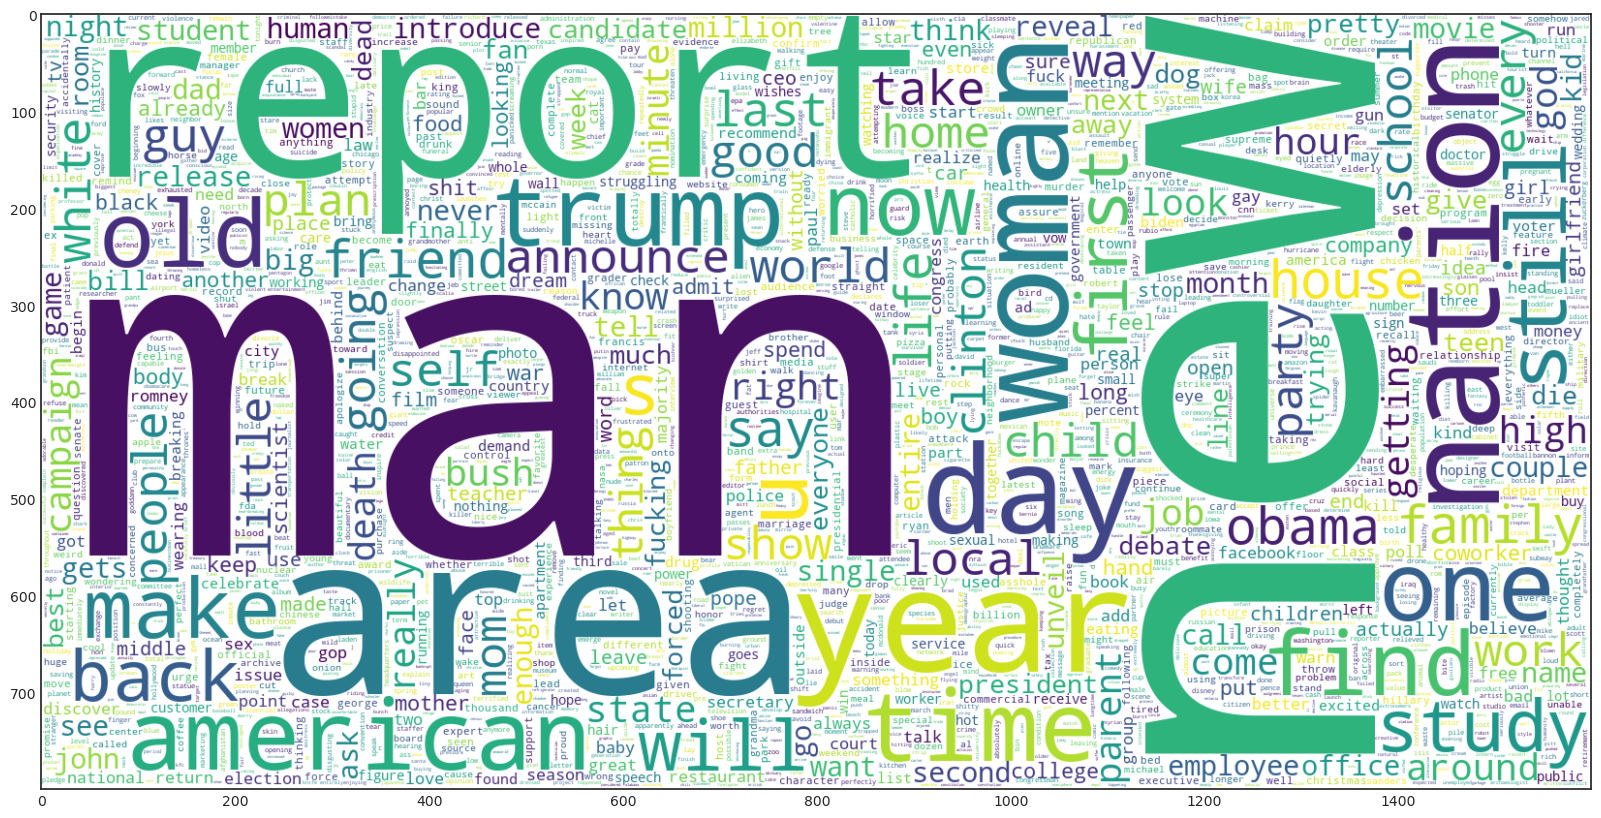

In [19]:
sarcastic_word = sarcastic['headline']
plt.figure(figsize = (20,20))
wc = WordCloud(stopwords=wordcloud.STOPWORDS,max_words =5000 , width = 1600 , height = 800,background_color="white",
               collocations=False).generate(" ".join(sarcastic_word))
plt.imshow(wc, interpolation='bilinear')

Most word are new, man and report

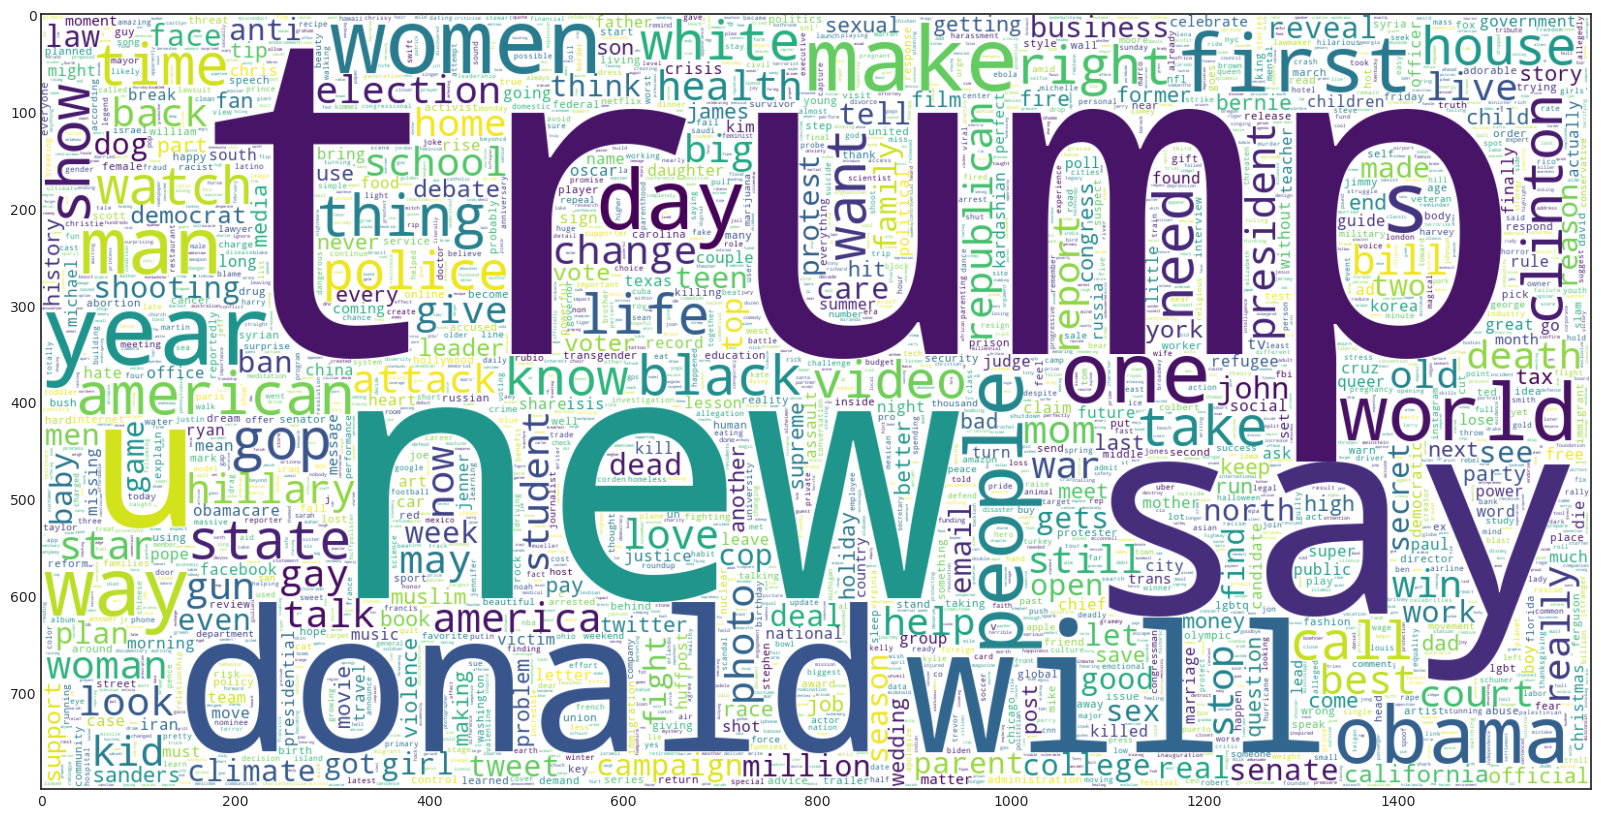

In [20]:
non_sarcastic_word = non_sarcastic['headline']
plt.figure(figsize = (20,20))
wc = WordCloud(stopwords=wordcloud.STOPWORDS,max_words = 5000 , width = 1600 , height = 800,background_color="white",
               collocations=False).generate(" ".join(non_sarcastic_word))
plt.imshow(wc, interpolation='bilinear')

Most word are focus on donald Trump

### Data Preprocessing

In this section we are going to clean our text data 

In [21]:
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
#stop_words.remove('no')
#stop_words.remove('not')
#stop_words.remove('your')

# load up a for wordnet
wnl = nltk.stem.WordNetLemmatizer()

def simple_text_preprocessor(document): 
    # lower case
    document = str(document).lower()
    
    # expand contractions
    document = contractions.fix(document)
    
    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub(r'nbsp', r'', document)
    document = re.sub(' +', ' ', document)
    
    # simple porter stemming
    document = ' '.join([wnl.lemmatize(word) for word in document.split()])
    
    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

clean_text = np.vectorize(simple_text_preprocessor)

The above function is inspired by **Dipanjan Sarkar**

In [22]:
train['headline_clean'] = clean_text(train['headline'].values)
test['headline_clean'] = clean_text(test['headline'].values)

In [23]:
train.head()

headline  is_sarcastic  \
0  supreme court votes 7-2 to legalize all worldl...             1   
1  hungover man horrified to learn he made dozens...             1   
2  emily's list founder: women are the 'problem s...             0   
3      send your kids back to school with confidence             0   
4          watch: experts talk pesticides and health             0   

                                      headline_clean  
0           supreme court vote legalize worldly vice  
1  hungover man horrified learn made dozen plan l...  
2   emily list founder woman problem solver congress  
3                    send kid back school confidence  
4                 watch expert talk pesticide health

### Data Visualization2 

Check the top 10 words after removing noise (stopword) from the data.

In [24]:
cw = pd.DataFrame(Counter(" ".join(train["headline_clean"]).split()).most_common(10),columns=['words', 'count'])

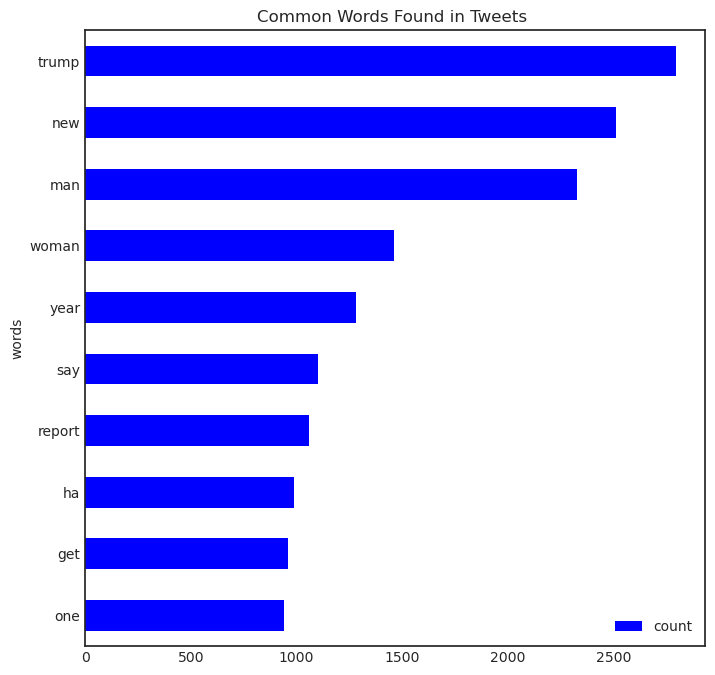

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
cw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="blue")

ax.set_title("Common Words Found in Tweets ")

plt.show()

Top 10 common word in the whole headline

In [26]:
new_sarcastic = train[train['is_sarcastic'] == 1].reset_index(drop=True)

new_non_sarcastic = train[train['is_sarcastic'] == 0].reset_index(drop=True)


In [27]:
ns = pd.DataFrame(Counter(" ".join(new_sarcastic["headline_clean"]).split()).most_common(10),columns=['words', 'count'])

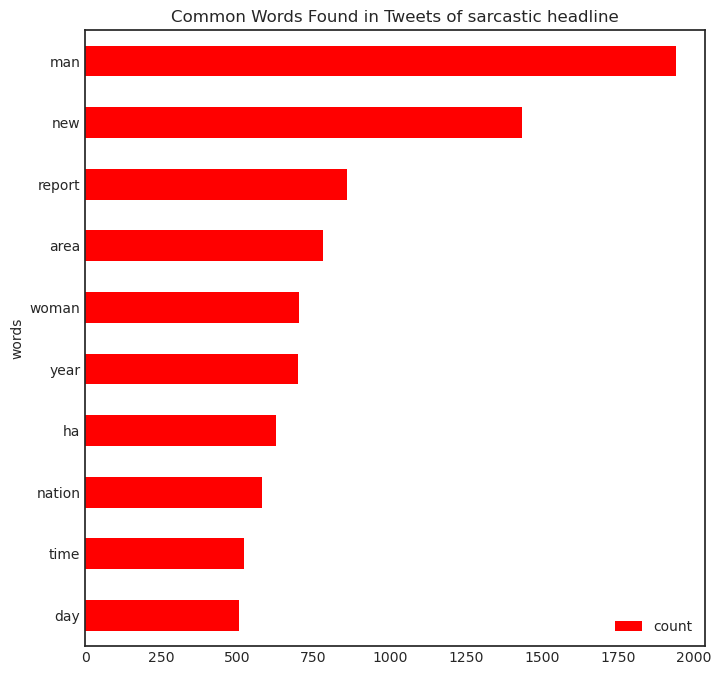

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
ns.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="red")

ax.set_title("Common Words Found in Tweets of sarcastic headline")

plt.show()

Top 10 common word found in sarcastic word.

In [29]:
nns = pd.DataFrame(Counter(" ".join(new_non_sarcastic["headline_clean"]).split()).most_common(10),columns=['words', 'count'])

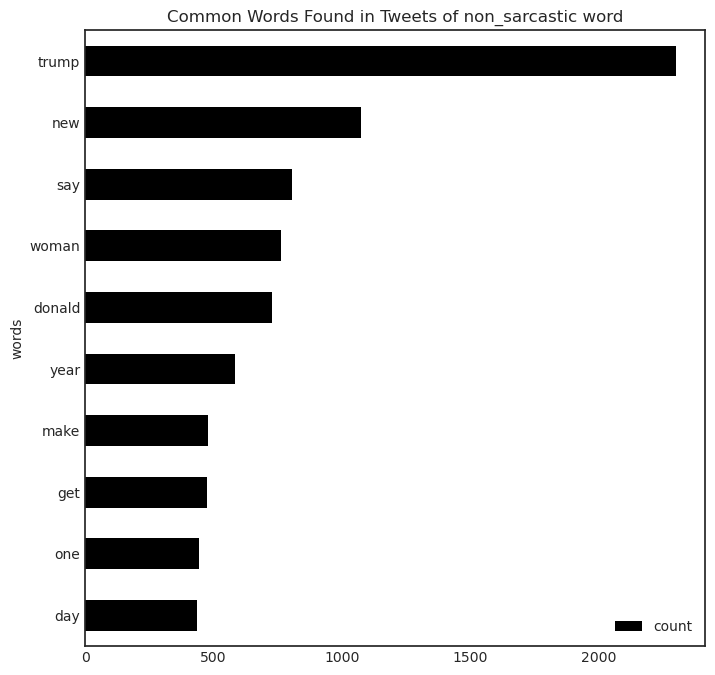

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
nns.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="black")

ax.set_title("Common Words Found in Tweets of non_sarcastic word")

plt.show()

Top 10 word found in non sarcastic word

### Feature engineering 

1. The first pre-processing is to enrich the data using sentiment analysis of each text

2. counting the word text

3. Using count word

4. 

In [31]:
train_sentiment_features = train['headline'].apply(lambda row: textblob.TextBlob(row).sentiment)
train['Polarity'] = [obj.polarity for obj in train_sentiment_features.values]
train['Subjectivity'] = [obj.subjectivity for obj in train_sentiment_features.values]

test_sentiment_features = test['headline'].apply(lambda row: textblob.TextBlob(row).sentiment)
test['Polarity'] = [obj.polarity for obj in test_sentiment_features.values]
test['Subjectivity'] = [obj.subjectivity for obj in test_sentiment_features.values]

In [32]:
train.head()

headline  is_sarcastic  \
0  supreme court votes 7-2 to legalize all worldl...             1   
1  hungover man horrified to learn he made dozens...             1   
2  emily's list founder: women are the 'problem s...             0   
3      send your kids back to school with confidence             0   
4          watch: experts talk pesticides and health             0   

                                      headline_clean  Polarity  Subjectivity  
0           supreme court vote legalize worldly vice       0.0      0.000000  
1  hungover man horrified learn made dozen plan l...       0.0      0.066667  
2   emily list founder woman problem solver congress       0.0      0.000000  
3                    send kid back school confidence       0.0      0.000000  
4                 watch expert talk pesticide health       0.0      0.000000

In [33]:
import string

train['char_count'] = train['headline'].apply(len)
train['word_count'] = train['headline'].apply(lambda x: len(x.split()))
train['word_density'] = train['char_count'] / (train['word_count']+1)
train['punctuation_count'] = train['headline'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train['title_word_count'] = train['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['upper_case_word_count'] = train['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


test['char_count'] = test['headline'].apply(len)
test['word_count'] = test['headline'].apply(lambda x: len(x.split()))
test['word_density'] = test['char_count'] / (test['word_count']+1)
test['punctuation_count'] = test['headline'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
test['title_word_count'] = test['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test['upper_case_word_count'] = test['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

## Using bag of words with N-gram


### Dimensionality reduction using support vector decomposition

In [34]:
CV = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))
trainCV = CV.fit_transform(train['headline_clean']).toarray()
trainCV = pd.DataFrame(trainCV, columns=CV.get_feature_names())

testCV = CV.fit_transform(test['headline_clean']).toarray()
testCV = pd.DataFrame(testCV, columns=CV.get_feature_names())
trainCV.head()

aaa  aaron  aarp  aatish  ab  abandon  abandoned  abandoning  abaya  abbas  \
0    0      0     0       0   0        0          0           0      0      0   
1    0      0     0       0   0        0          0           0      0      0   
2    0      0     0       0   0        0          0           0      0      0   
3    0      0     0       0   0        0          0           0      0      0   
4    0      0     0       0   0        0          0           0      0      0   

   ...  zoo  zookeeper  zoolander  zoologist  zoomed  zoroastrianism  zsa  \
0  ...    0          0          0          0       0               0    0   
1  ...    0          0          0          0       0               0    0   
2  ...    0          0          0          0       0               0    0   
3  ...    0          0          0          0       0               0    0   
4  ...    0          0          0          0       0               0    0   

   zucker  zuckerberg  zz  
0       0           0   0  
1       0           0   0  
2       0           0   0  
3       0           0   0  
4       0           0   0  

[5 rows x 22053 columns]

In [37]:
svd = TruncatedSVD(n_components=50)

In [38]:
n_comp = 50

In [39]:
svd_train = svd.fit_transform(trainCV)

In [40]:
svd_test = svd.fit_transform(testCV)

In [41]:
svd_train = pd.DataFrame(svd_train, columns=['svd_char_'+str(i) for i in range(n_comp)])
svd_test = pd.DataFrame(svd_test, columns=['svd_char_'+str(i) for i in range(n_comp)])

### Using TF-idf features

tfv = TfidfVectorizer(
            stop_words = 'english')

traintfv = tfv.fit_transform(train['headline_clean']).toarray()
traintfv = pd.DataFrame(traintfv, columns=tfv.get_feature_names())

testtfv = tfv.fit_transform(test['headline_clean']).toarray()
testtfv = pd.DataFrame(testtfv, columns=tfv.get_feature_names())
traintfv.head()

 ## combining the data

In [42]:
data = pd.concat([train, svd_train], axis=1)
test_data = pd.concat([test, svd_test], axis=1)

In [43]:
#data = pd.concat([train, trainCV], axis=1)
#test_data = pd.concat([test, testCV], axis=1)

In [44]:
X=data.drop(['is_sarcastic', 'headline', 'headline_clean'], axis=1)
y=data['is_sarcastic']

In [45]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =2021, stratify=y)

In [46]:
print('Shape of the X_train {}'.format(X_train.shape))
print('Shape of the y_train {}'.format(y_train.shape))
print('Shape of the X_test {}'.format(X_test.shape))
print('Shape of the y_test {}'.format(y_test.shape))

Shape of the X_train (35409, 58)
Shape of the y_train (35409,)
Shape of the X_test (8853, 58)
Shape of the y_test (8853,)


In [47]:
algos = [LogisticRegression(), 
        RandomForestClassifier(max_depth=5,n_estimators=1000, max_features='auto', class_weight='balanced'),
        DecisionTreeClassifier(max_depth=5),
        CatBoostClassifier(eval_metric='Accuracy', metric_period=20, logging_level='Silent'),
        LGBMClassifier(n_estimators=500),
         XGBClassifier(max_depth=4, n_estimators=500)]

names = ['Logistic_Regression',  'RandomForest','Decision_Tree','Catboost', 'Lightgbm', 'Xgboost']
accuracy_list = []

In [48]:
for name in algos:
    model = name
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy= accuracy_score(y_test,y_pred)
    accuracy_list.append(accuracy)

In [49]:
evaluation = pd.DataFrame({'Model': names,
                           'Accuracy_Score': accuracy_list})

In [50]:
evaluation.sort_values(by='Accuracy_Score', ascending=False)

Model  Accuracy_Score
4             Lightgbm        0.863436
5              Xgboost        0.848752
3             Catboost        0.801310
0  Logistic_Regression        0.697052
1         RandomForest        0.694680
2        Decision_Tree        0.664408

In [51]:
confusion_matrix(y_test, algos[4].predict(X_test))

array([[4263,  529],
       [ 680, 3381]])

In [52]:
confusion_matrix(y_test, algos[3].predict(X_test))

array([[4030,  762],
       [ 997, 3064]])

<AxesSubplot:xlabel='Model', ylabel='Accuracy_Score'>

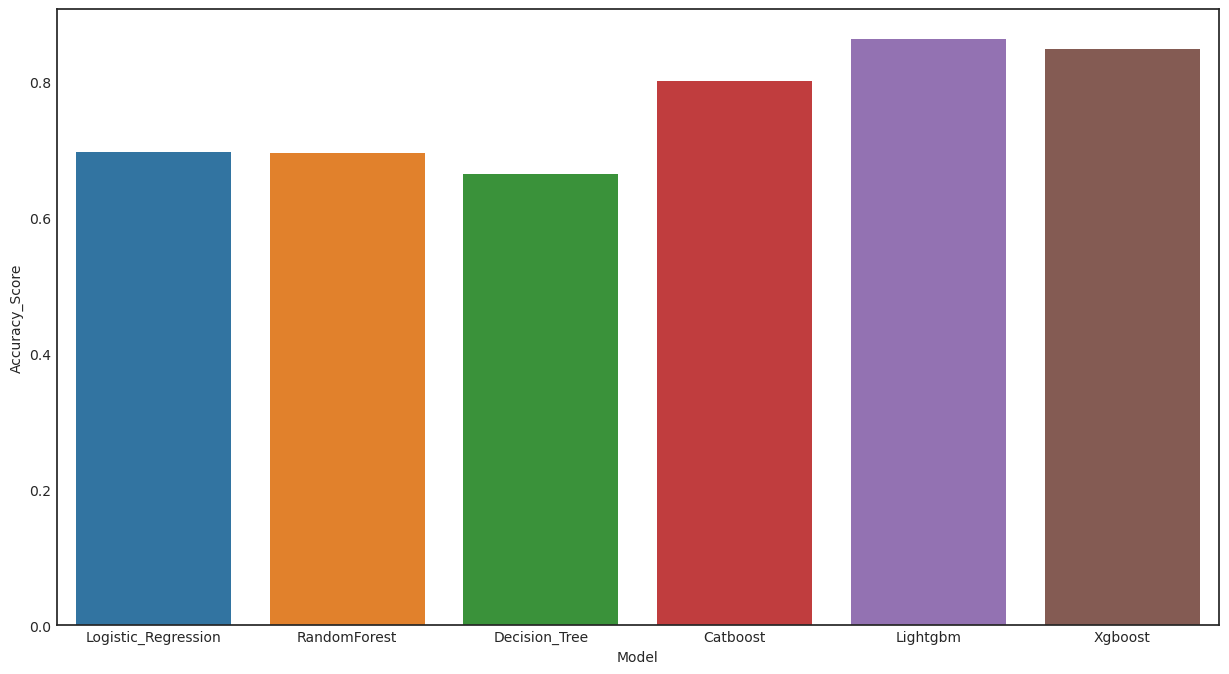

In [53]:
rcParams['figure.figsize'] = 15,8
sns.barplot(data=evaluation,x='Model', y='Accuracy_Score')

Lightgbm is the best model

### PREDICT THE TEST DATA

In [54]:
X=data.drop(['is_sarcastic', 'headline', 'headline_clean'], axis=1)
y=data['is_sarcastic']

In [55]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =2021, stratify=y)

In [56]:
test_data = test_data.drop(['headline', 'headline_clean'], axis=1)

In [57]:
model = LGBMClassifier(num_leaves=102, colsample_bytree=0.7, subsample=0.9)#LGBMClassifier(n_estimators=500)

In [58]:
model.fit(X,y)

LGBMClassifier(colsample_bytree=0.7, num_leaves=102, subsample=0.9)

In [59]:
test_data.shape

(11066, 58)

In [60]:
test_prediction = model.predict(test_data)

In [61]:
test_prediction

array([0, 1, 0, ..., 0, 1, 1])

In [62]:
submit = pd.DataFrame(test_prediction, columns=['prediction'])

In [63]:
submit.head()

prediction
0           0
1           1
2           0
3           1
4           0

In [64]:
submit['prediction'].value_counts()

0    6064
1    5002
Name: prediction, dtype: int64

In [65]:
submit.to_csv('Submission.csv', index=False)